In [1]:
%cd ../..
import time
from os import environ
# ego = Car on drivableRoad,
#         facing Range(-15, 15) deg relative to roadDirection,
#         with visibleDistance 50,
#         with viewAngle 135 deg

# other1 = Car on intersection,
#             facing Range(50, 135) deg relative to ego.heading

# other2 = Car on intersection,
#             facing -1 * Range(50, 135) deg relative to ego.heading

# require abs(relative heading of other1 from other2) > 100 deg
# require (distance from ego to intersectionRegion) < 10

c:\Users\youse\Desktop\Research\Apperception\apperception


In [2]:
if "AP_PORT" not in environ:
    environ["AP_PORT"] = "25432" #str(input('port'))

In [3]:
"""
with (
  select *
  from item_traj
  where item_traj.object_type = 'car'
) as cars

select *
from cars as t1
join cars as t2 on t1.cameraId = t2.cameraId
join Cameras as cam on t1.cameraId = Cameras.id
where
  facingRelative(cam.egoHeading, road_direction(cam.ego_translation), cam.timestamp) >= -15 AND
  facingRelative(cam.egoHeading, road_direction(cam.ego_translation), cam.timestamp) <= 15 AND
  DISTANCE(cam.egoTranslation, t1.centroid, cam.timestamp) < 50 AND
  viewAngle(t1.traj, cam.egoHeading, cam.ego_Translation, cam.timestamp) < 135 AND
  DISTANCE(cam.egoTranslation, t2.centroid, cam.timestamp) < 50 AND
  viewAngle(t2.traj, cam.egoHeading, cam.ego_Translation, cam.timestamp) < 135 AND
  contained(t1.traj, road_segment_type("intersection"), cam.timestamp) and
  contained(t2.traj, road_segment_type("intersection"), cam.timestamp) and
  (facingRelative(t1.heading, cam.egoHeading, cam.timestamp) < -50 ANd
  facingRelative(t1.heading, cam.egoHeading, cam.timestamp) > -135) AND
  (facingRelative(t2.heading, cam.egoHeading, cam.timestamp) < -50 AND
  facingRelative(t2.heading, cam.egoHeading, cam.timestamp) > -135) AND
  DISTANCE(cam.egoTranslation, roadSection("intersection"), cam.timestamp) < 10 AND
  (facingRelative(t1.heading, t2.heading, cam.timestamp) > 100 OR
  facingRelative(t1.heading, t2.heading, cam.timestmap) < -100)

"""

'\nwith (\n  select *\n  from item_traj\n  where item_traj.object_type = \'car\'\n) as cars\n\nselect *\nfrom cars as t1\njoin cars as t2 on t1.cameraId = t2.cameraId\njoin Cameras as cam on t1.cameraId = Cameras.id\nwhere\n  facingRelative(cam.egoHeading, road_direction(cam.ego_translation), cam.timestamp) >= -15 AND\n  facingRelative(cam.egoHeading, road_direction(cam.ego_translation), cam.timestamp) <= 15 AND\n  DISTANCE(cam.egoTranslation, t1.centroid, cam.timestamp) < 50 AND\n  viewAngle(t1.traj, cam.egoHeading, cam.ego_Translation, cam.timestamp) < 135 AND\n  DISTANCE(cam.egoTranslation, t2.centroid, cam.timestamp) < 50 AND\n  viewAngle(t2.traj, cam.egoHeading, cam.ego_Translation, cam.timestamp) < 135 AND\n  contained(t1.traj, road_segment_type("intersection"), cam.timestamp) and\n  contained(t2.traj, road_segment_type("intersection"), cam.timestamp) and\n  (facingRelative(t1.heading, cam.egoHeading, cam.timestamp) < -50 ANd\n  facingRelative(t1.heading, cam.egoHeading, cam.time

In [4]:
### Prepare the world for queries ###
from apperception.world import empty_world
from apperception.database import database
# directly ingest the mini dataset and boston roadnetwork if needed
# from apperception.new_db import database
# database.reset()
# from benchmarks.ingest_scenic_data import ingest_data
# ingest_data()

name = 'ScenicWorld' # world name
world = empty_world(name=name)

### Query ###
from apperception.utils import F


def pred(obj1, obj2, cam):
    return (
        F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp), cam.timestamp) >= -15 and
        F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp), cam.timestamp) <= 15 and
        F.distance(cam.ego, obj1, cam.timestamp) < 50 and
        F.viewAngle(obj1, cam.ego, cam.timestamp) < (70 / 2) and
        F.distance(cam.ego, obj2, cam.timestamp) < 50 and
        F.viewAngle(obj2, cam.ego, cam.timestamp) < (70 / 2) and
        F.contained(obj1.traj, F.road_segment("intersection"), cam.timestamp) and
        F.contained(obj2.traj, F.road_segment("intersection"), cam.timestamp) and
        (F.facing_relative(obj1, cam.ego, cam.timestamp) < -50 or
            F.facing_relative(obj1, cam.ego, cam.timestamp) > -135) and
        (F.facing_relative(obj2, cam.ego, cam.timestamp) < -50 or
            F.facing_relative(obj2, cam.ego, cam.timestamp) > -135) and
        F.distance(cam.ego, roadSection(obj1.traj, cam.timestamp)) < 10 and
        (F.facing_relative(obj1, obj2, cam.timestamp) > 100 or
            F.facing_relative(obj1, obj2, cam.timestamp) < -100)
    )
world = world.filter("lambda obj1, obj2, cam: " +
    "obj1.object_id != obj2.object_id and " +
    "F.like(obj1.object_type, 'vehicle%') and " +
    "F.like(obj2.object_type, 'vehicle%') and " +
    "F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.ego)), -15, 15) and " +
    "F.distance(cam.ego, obj1, cam.timestamp) < 50 and " +
    "F.view_angle(obj1, cam.ego, cam.timestamp) < 70 / 2.0 and " +
    "F.distance(cam.ego, obj2, cam.timestamp) < 50 and " +
    "F.view_angle(obj2, cam.ego, cam.timestamp) < 70 / 2.0 and " +
    "F.contains_all('intersection', [obj1.traj, obj2.traj]@cam.timestamp) and "
    "F.angle_between(F.facing_relative(obj1, cam.ego, cam.timestamp), 50, 135) and " +
    "F.angle_between(F.facing_relative(obj2, cam.ego, cam.timestamp), -135, -50) and " +
    "F.minDistance(cam.egoTranslation, F.road_segment('intersection')) < 10 and " +
    "F.angle_between(F.facing_relative(obj1, obj2, cam.timestamp), 100, -100) and " +
    # "F.like(cam.filename, '%n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535656773912404.jpg') and " +
    "1 == 1;"
)

start = time.time()

id_time_camId_filename = world.get_id_time_camId_filename(2)

end = time.time()
print(format(end-start))

execute: filter
execute: get_id_time_camId_filename
get_id_time_camId_filename 
        SELECT table_0.itemId,table_1.itemId, cameras.timestamp, cameras.cameraId, cameras.filename
        FROM (SELECT * FROM item_general_trajectory) as table_0
        JOIN (SELECT * FROM item_general_trajectory) as table_1 USING (cameraId)
        JOIN Cameras USING (cameraId)
        WHERE ((table_0.itemId<>table_1.itemId) AND (table_0.objectType LIKE 'vehicle%') AND (table_1.objectType LIKE 'vehicle%') AND angleBetween(facingRelative(Cameras.egoHeading, roadDirection(Cameras.egoTranslation, Cameras.egoHeading)), (-15), 15) AND (distance(Cameras.egoTranslation, table_0.trajCentroids, Cameras.timestamp)<50) AND (viewAngle(table_0.trajCentroids, Cameras.egoHeading, Cameras.egoTranslation, Cameras.timestamp)<(70/2.0)) AND (distance(Cameras.egoTranslation, table_1.trajCentroids, Cameras.timestamp)<50) AND (viewAngle(table_1.trajCentroids, Cameras.egoHeading, Cameras.egoTranslation, Cameras.timestamp)<(70/

In [5]:
data_dir =  "data/nuscenes/experiment_data"

world.overlay_trajectory(images_data_path=data_dir, overlay_headings=True, overlay_objects=True, overlay_road=True, keep_whole_video=True)

execute: filter
execute: get_id_time_camId_filename
get_id_time_camId_filename 
        SELECT table_0.itemId, cameras.timestamp, cameras.cameraId, cameras.filename
        FROM (SELECT * FROM item_general_trajectory) as table_0
        JOIN (SELECT * FROM item_general_trajectory) as table_1 USING (cameraId)
        JOIN Cameras USING (cameraId)
        WHERE ((table_0.itemId<>table_1.itemId) AND (table_0.objectType LIKE 'vehicle%') AND (table_1.objectType LIKE 'vehicle%') AND angleBetween(facingRelative(Cameras.egoHeading, roadDirection(Cameras.egoTranslation, Cameras.egoHeading)), (-15), 15) AND (distance(Cameras.egoTranslation, table_0.trajCentroids, Cameras.timestamp)<50) AND (viewAngle(table_0.trajCentroids, Cameras.egoHeading, Cameras.egoTranslation, Cameras.timestamp)<(70/2.0)) AND (distance(Cameras.egoTranslation, table_1.trajCentroids, Cameras.timestamp)<50) AND (viewAngle(table_1.trajCentroids, Cameras.egoHeading, Cameras.egoTranslation, Cameras.timestamp)<(70/2.0)) AND (EXIS

In [6]:
from apperception.data_types import QueryType, Trajectory
import datetime
query = f"""
        SELECT asMFJSON(trajCentroids)::json->'sequences'
        FROM Item_General_Trajectory as final
        WHERE itemId = '9d03c6edb6eb4d49acccb245bdd0c652'
        """

t = database._execute_query(query)[0][0][0]
coordinates = t["coordinates"]
datetimes = t["datetimes"]
result = {}
for coord, time in zip(coordinates, datetimes):
    dt_time = datetime.datetime.strptime(time, "%Y-%m-%dT%H:%M:%S.%f+00").replace(tzinfo=datetime.timezone.utc)
    result[dt_time] = coord

print(result)


{datetime.datetime(2018, 9, 18, 9, 15, 58, 412404, tzinfo=datetime.timezone.utc): [2522.209156293894, 893.7414083340166, 0.12]}


In [5]:
# for k in id_time_camId_filename:
#     print(k[-2], str(k[-3]), k[-1])
#     print("                                           ", *k[:-3])

In [6]:
resultImages = dict() # maping from image -> (itemId, timestamp, camId) that it was found at
for result in id_time_camId_filename:
    itemId1, itemId2, timestamp, camId, filename = result
    filename = filename.split("/")[-1] # use split so that prefix path is not included in filename
    if filename not in resultImages:
        resultImages[filename] = []
    resultImages[filename].append((itemId1, itemId2, timestamp, camId))

In [7]:
from show_images import show_images
%matplotlib inline

data_dir =  "data/nuscenes/experiment_data"
# data_dir = '/work/apperception/data/nuScenes/full-dataset-v1.0/Trainval/experiment_data'
# data_dir = '/Users/chanwutk/Documents/experiment_data'

image n008-2018-09-18-12-07-26-0400__CAM_FRONT__1537287358412404.jpg
('9d03c6edb6eb4d49acccb245bdd0c652', '65d120d480794b9fbb433dc58512559b', datetime.datetime(2018, 9, 18, 9, 15, 58, 412404, tzinfo=datetime.timezone.utc), 'scene-0456')
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118112404.jpg
('82d680066ddd465dbd3b22fd6a66ed70', '58350757f1d04f628aab9b22cf33549b', datetime.datetime(2018, 8, 30, 12, 25, 18, 112404, tzinfo=datetime.timezone.utc), 'scene-0757')
('b327acc1048e44889108740b2304dabc', '58350757f1d04f628aab9b22cf33549b', datetime.datetime(2018, 8, 30, 12, 25, 18, 112404, tzinfo=datetime.timezone.utc), 'scene-0757')
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118612404.jpg
('b327acc1048e44889108740b2304dabc', '58350757f1d04f628aab9b22cf33549b', datetime.datetime(2018, 8, 30, 12, 25, 18, 612404, tzinfo=datetime.timezone.utc), 'scene-0757')
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657119112404.jpg
('b327acc1048e44889108740b23

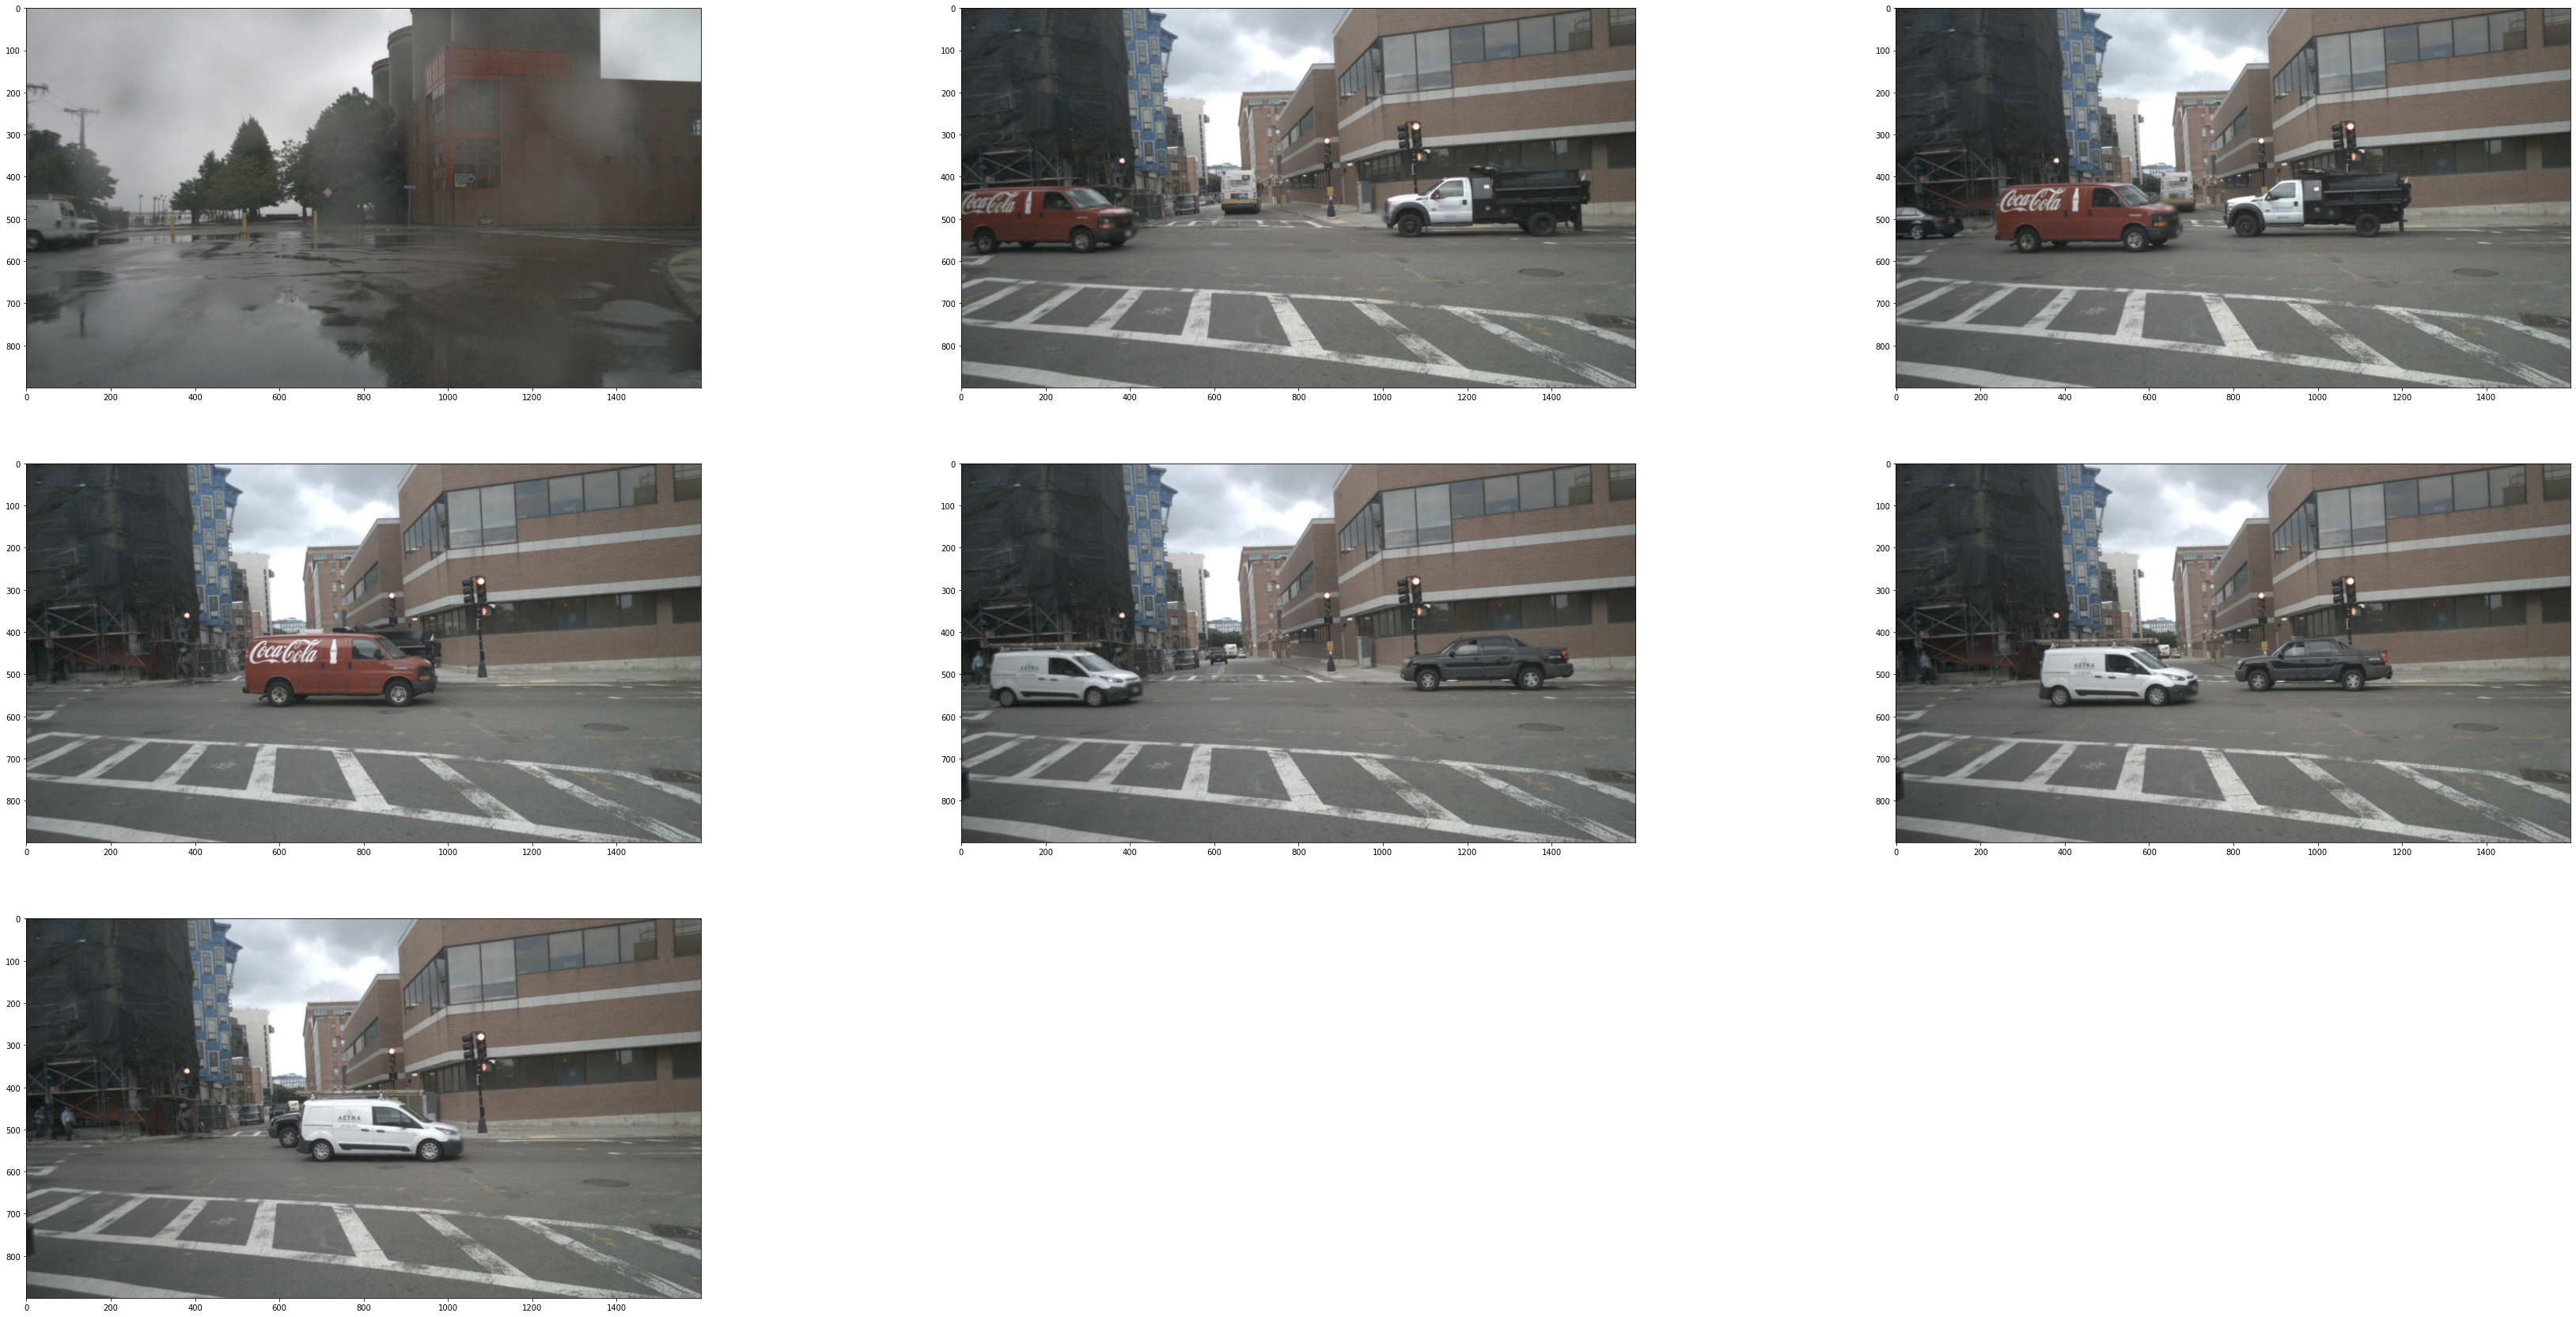

In [8]:
show_images(data_dir, resultImages, sample=10)

In [9]:
query = f"""
CREATE OR REPLACE FUNCTION ST_XYZ (g geometry) RETURNS real[] AS $$
    BEGIN
        RETURN ARRAY[ST_X(g), ST_Y(g), ST_Z(g)];
    END;
$$ LANGUAGE plpgsql;

SELECT
    cameraId,
    ST_XYZ(egoTranslation),
    egoRotation,
    ST_XYZ(cameraTranslation),
    ST_XYZ(cameraTranslationAbs),
    cameraRotation,
    cameraIntrinsic,
    frameNum,
    fileName,
    cameraHeading,
    egoHeading
FROM Cameras
WHERE
    fileName = 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118112404.jpg'
ORDER BY cameraId ASC, frameNum ASC;
"""
# print(query)
result = database._execute_query(query)

image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118112404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657119112404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657127612404.jpg
loaded
image n008-2018-09-18-12-07-26-0400__CAM_FRONT__1537287358412404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118612404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657127112404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657128112404.jpg
loaded


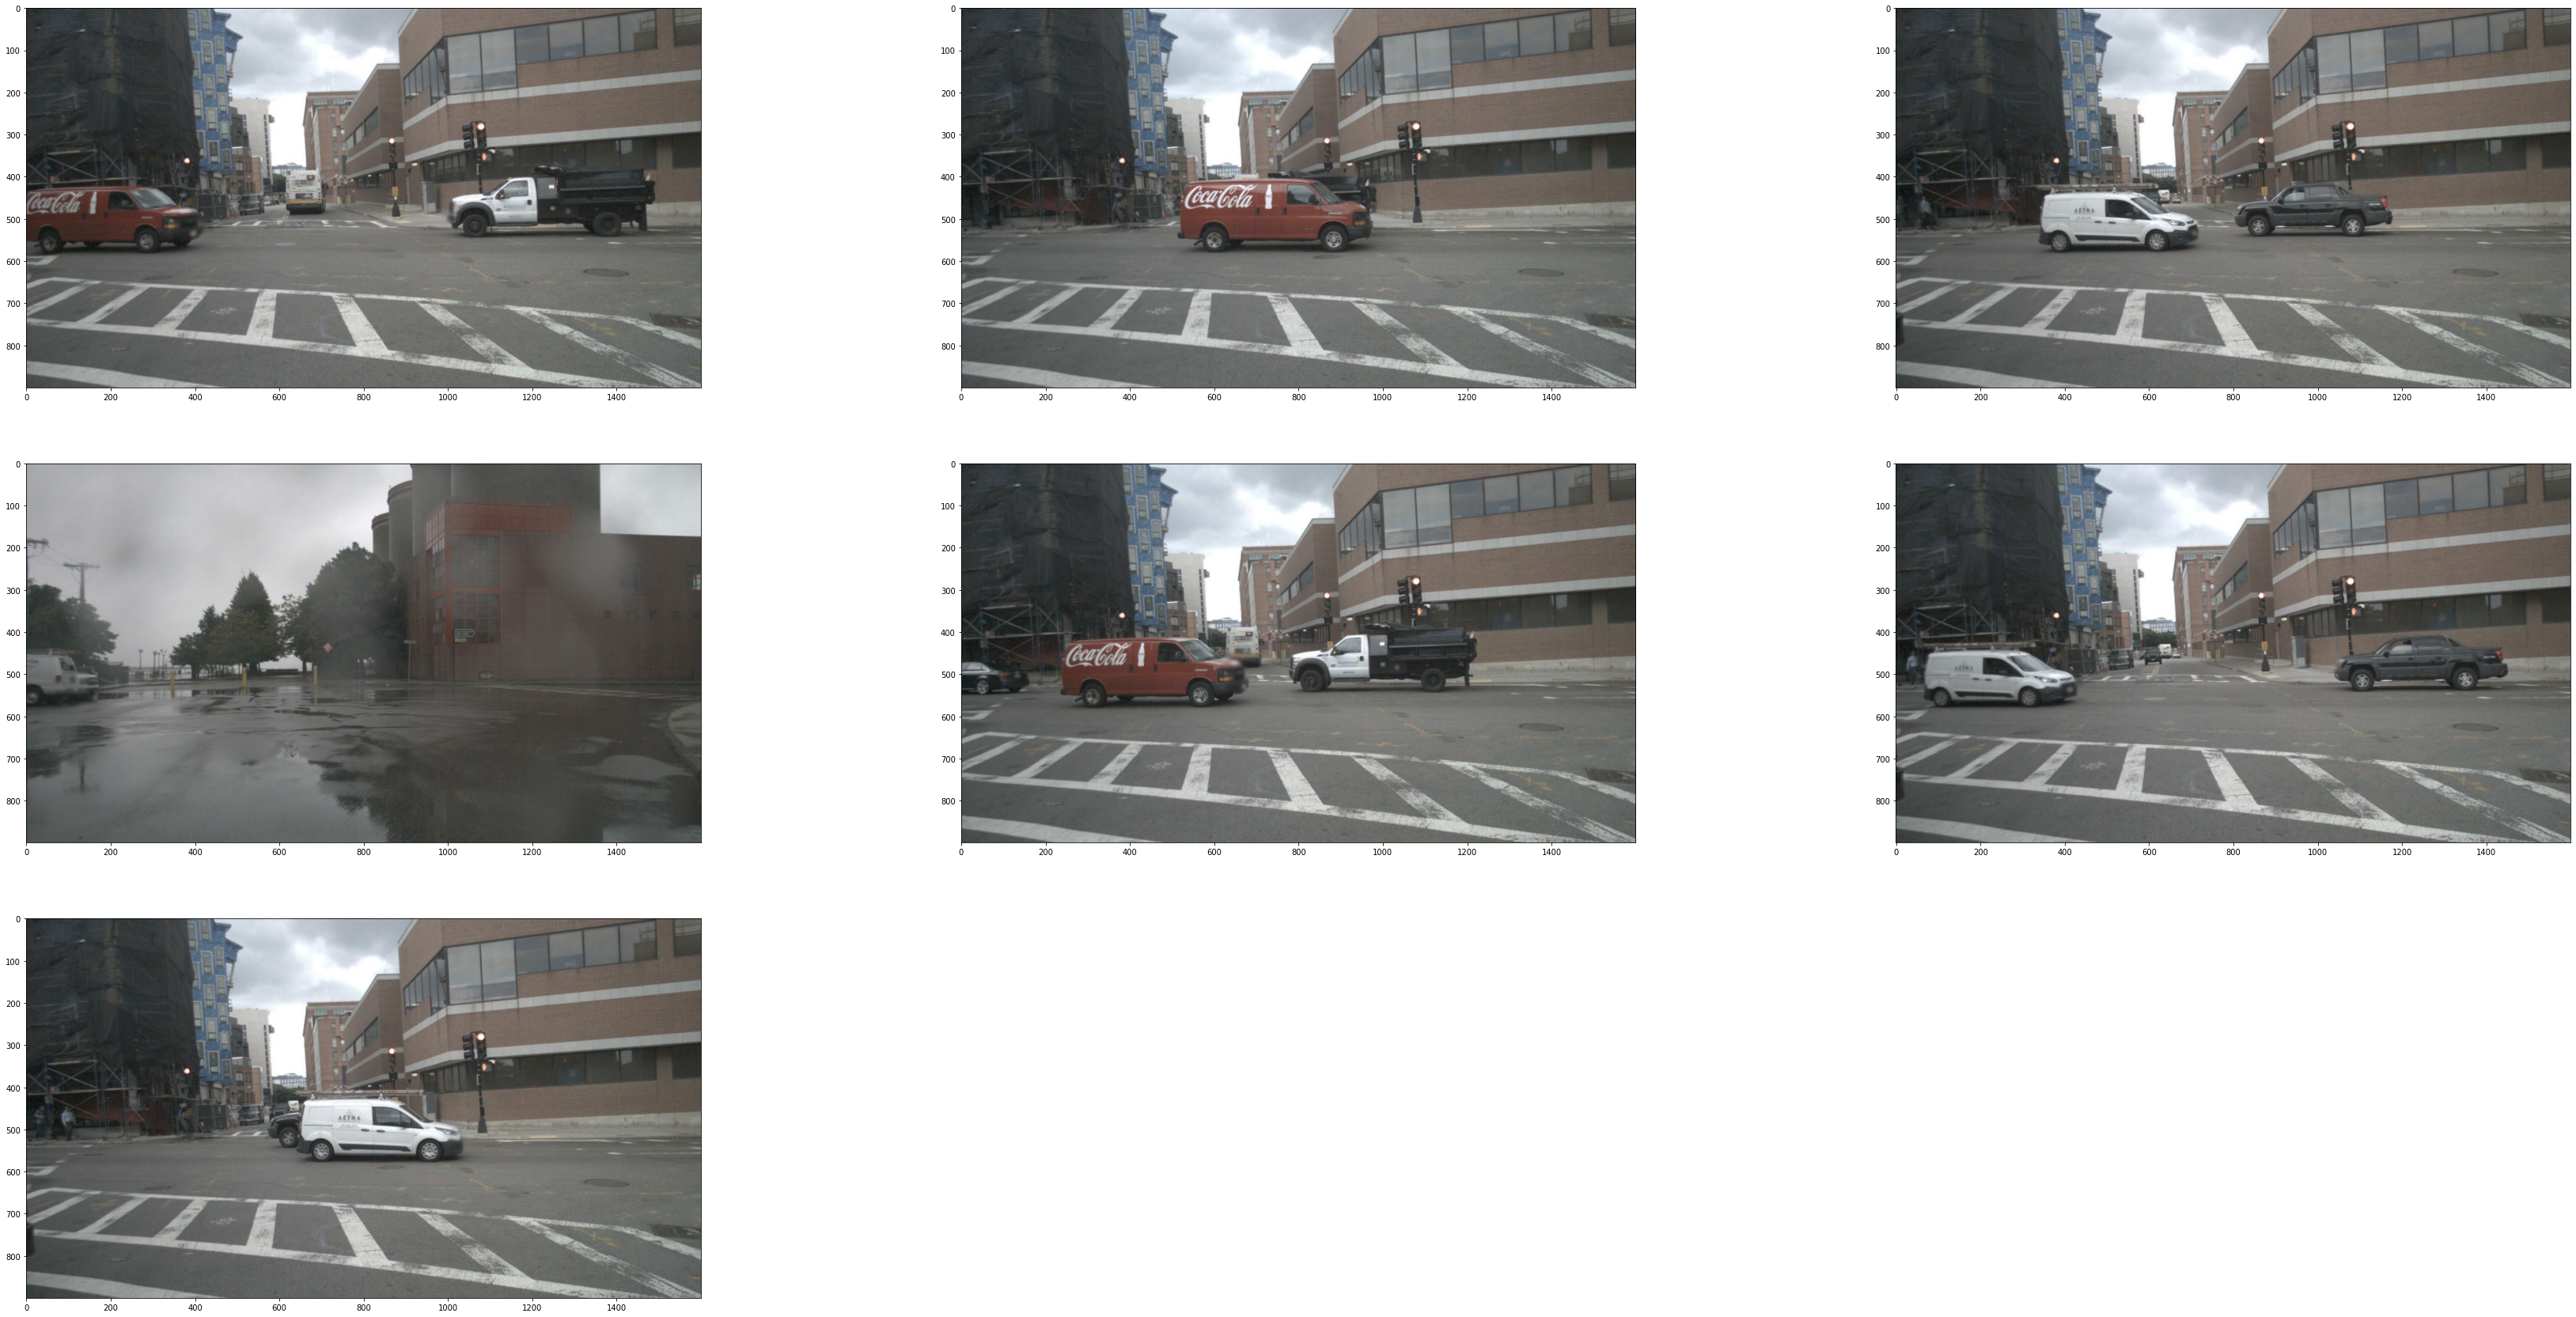

In [9]:
expected_imgs = [
    'n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118112404.jpg',
    'n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657119112404.jpg',
    'n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657127612404.jpg',
    'n008-2018-09-18-12-07-26-0400__CAM_FRONT__1537287358412404.jpg',
    'n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118612404.jpg',
    'n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657127112404.jpg',
    'n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657128112404.jpg',
]
show_images(data_dir, expected_imgs, sample=10)

In [10]:
missing = 0
missing_images = []
for expected_img in expected_imgs:
    if expected_img not in resultImages.keys():
        missing += 1
        missing_images.append(expected_img)
print("Percentage of expected results missing from query: ", missing, "/", len(expected_imgs), "=", 100 * missing / len(expected_imgs), "%")
show_images(data_dir, missing_images, sample=10)

Percentage of expected results missing from query:  0 / 7 = 0.0 %


<Figure size 4320x2160 with 0 Axes>

In [11]:
extra = 0
extra_images = {}
for img in resultImages.keys():
    if img not in expected_imgs:
        extra += 1
        extra_images[img] = resultImages[img]
print("Percentage of images in query but not in expected results: ", extra, "/", len(resultImages.keys()), "=", 100 * extra / len(resultImages.keys()), "%")
show_images(data_dir, extra_images, sample=10, seed=5)

Percentage of images in query but not in expected results:  0 / 7 = 0.0 %


<Figure size 4320x2160 with 0 Axes>